<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/HAR/UCI_HAR_ResNet%2Btransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
import os
import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import keras

In [284]:
#라벨 정리
ACTIVITIES={
    0:'WALKING',
    1:'WALKING_UPSTAIRS',
    2:'WALKING_DOWNSTAIRS',
    3:'SITTING',
    4:'STANDING',
    5:'LAYING'
}

In [285]:
#혼돈행렬 함수
def confustion_matrix(Y_true, Y_pred):
  Y_true=pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
  Y_pred=pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

  return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [286]:
DATADIR= os.path.join(os.getcwd(), 'drive','MyDrive','datasets')

SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"]

In [287]:
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename= DATADIR + f'/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)

    return np.transpose(signals_data, (1, 2, 0))

In [288]:
def load_y(subset):
    filename= DATADIR + f'/UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = pd.read_csv(filename, delim_whitespace=True, header=None)[0]
    return pd.get_dummies(y).values

In [289]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, y_train, X_test,  y_test

In [290]:
np.random.seed(36)
rn.seed(36)
tf.random.set_seed(36)

In [291]:
#라벨 개수 세기
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [292]:
#전에 정리한 데이터셋 불러오기
X_train, Y_train, X_val, Y_val= load_signals('train'), load_y('train'), load_signals('test'), load_y('test')

/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd

In [293]:
class scaling_tseries_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scale = None
    def fit(self, X, y=None):
        Xf = X.reshape(-1, X.shape[-1])
        self.scale = StandardScaler().fit(Xf)
        return self
    def transform(self, X):
        Xf = X.reshape(-1, X.shape[-1])
        Xf = self.scale.transform(Xf)
        return Xf.reshape(X.shape)

Scale = scaling_tseries_data().fit(X_train)
X_train_sc = Scale.transform(X_train)
X_val_sc   = Scale.transform(X_val)

### ResNet+transformer encoder

In [294]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Flatten, Layer, Embedding, Activation
)

In [295]:
def resnet_block_1d(inputs, filters, kernel_size=5, downsample=False):
    strides = 2 if downsample else 1

    x = Conv1D(filters, kernel_size,
               strides=strides,
               padding="same",
               kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)


    x = Conv1D(filters, kernel_size,
               strides=1,
               padding="same",
               kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    # 스킵 커넥션 (Skip Connection)
    skip = inputs

    # 1. 시퀀스 길이가 줄어들었거나 (downsample=True)
    # 2. 채널(필터) 수가 달라진 경우
    # 스킵 커넥션 경로에도 1x1 Conv를 적용하여 shape 맞춰주기....
    if downsample or (inputs.shape[-1] != filters):
        skip = Conv1D(filters, 1, # 1x1 Conv로 차원 맞추기
                      strides=strides, # 동일한 stride 적용
                      padding="same",
                      kernel_initializer="he_normal")(inputs)
        skip = BatchNormalization()(skip)

    # 주 경로와 스킵 커넥션 합산
    x = Add()([x, skip])
    x = Activation("relu")(x)
    return x

In [296]:
class PositionalEmbedding(Layer):
    def __init__(self, seq_len, d_model, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.d_model = d_model
        self.pos_emb = Embedding(input_dim=seq_len, output_dim=d_model)
        self.seq_len = seq_len

    def call(self, x):
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        embedded_positions = self.pos_emb(positions)
        return x + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'seq_len': self.seq_len,
            'd_model': self.d_model,
        })
        return config

In [297]:
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout=0.1):
  #멀티헤드 어텐션
  attn_input=LayerNormalization(epsilon=1e-6)(inputs)
  attention=MultiHeadAttention(
      num_heads=num_heads, key_dim=d_model//num_heads
  )(attn_input, attn_input)
  attention=Dropout(dropout)(attention)
  attn_output=Add()([inputs, attention])
  #피드포워드 네트워크
  ffn_input=LayerNormalization(epsilon=1e-6)(attn_output)
  ffn_output=Dense(ff_dim, activation="relu")(ffn_input)
  ffn_output=Dropout(dropout)(ffn_output)
  ffn_output=Dense(d_model)(ffn_output)
  return Add()([attn_output, ffn_output])

In [298]:
from tensorflow.keras import regularizers
def build_resnet_transformer(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, num_transformer_blocks=2):
    inputs = Input(shape=input_shape)

    #ResNet 특징 추출기
    x = Conv1D(filters=32, kernel_size=7, strides=2, padding="same", kernel_regularizer=regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # (None, 63, 32)

    #ResNet Blocks
    x = resnet_block_1d(x, filters=32, downsample=True)
    x = resnet_block_1d(x, filters=32, downsample=False)
    # (None, 32, 32)

    #ResNet Block
    x = resnet_block_1d(x, filters=d_model, downsample=True)
    x = resnet_block_1d(x, filters=d_model, downsample=False)
    # (None, 16, 64)

    #Transformer 인코더
    seq_len_after_resnet = x.shape[1]
    x = PositionalEmbedding(seq_len=seq_len_after_resnet, d_model=d_model)(x)
    x = Dropout(0.2)(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder_block(x, d_model, num_heads, ff_dim)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [299]:
INPUT_SHAPE = (X_train_sc.shape[1], X_train_sc.shape[2])
NUM_CLASSES = Y_train.shape[1]


resnet_model = build_resnet_transformer(
    INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=1
)

import tensorflow as tf
from tensorflow import keras

resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.F1Score(average='macro', name='f1_macro')
    ]
)

resnet_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_132 (Conv1D) │ (None, 64, 32)    │      2,048 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 32)    │        128 │ conv1d_132[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_108      │ (None, 64, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_133 (Conv1D) │ (None, 32, 32)    │      5,152 │ activation_108[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_133[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_109      │ (None, 32, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_134 (Conv1D) │ (None, 32, 32)    │      5,152 │ activation_109[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_135 (Conv1D) │ (None, 32, 32)    │      1,056 │ activation_108[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_134[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_135[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_76 (Add)        │ (None, 32, 32)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_110      │ (None, 32, 32)    │          0 │ add_76[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_136 (Conv1D) │ (None, 32, 32)    │      5,152 │ activation_110[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_136[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_111      │ (None, 32, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_137 (Conv1D) │ (None, 32, 32)    │      5,152 │ activation_111[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32)    │        128 │ conv1d_137[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_77 (Add)        │ (None, 32, 32)    │          0 │ batch_normalizat

 Total params: 138,854 (542.40 KB)

 Trainable params: 137,830 (538.40 KB)

 Non-trainable params: 1,024 (4.00 KB)

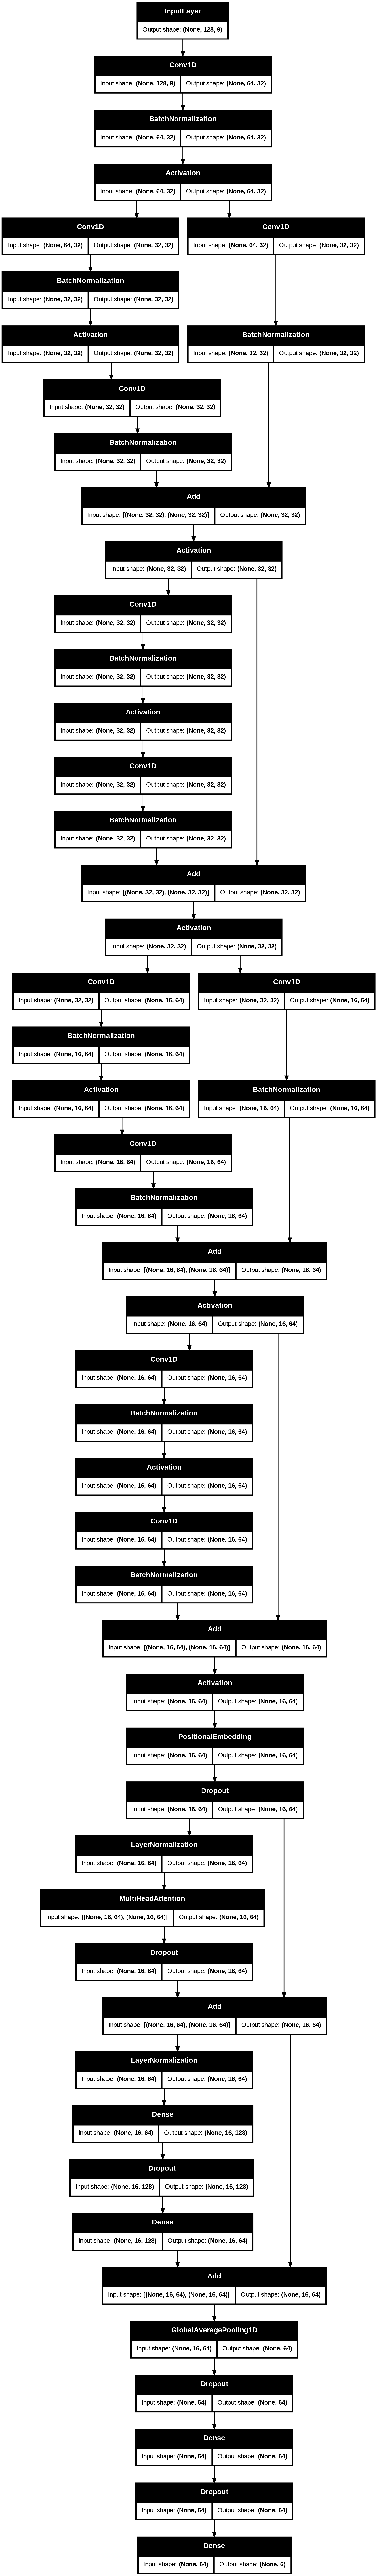

In [300]:
import tensorflow as tf
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

In [301]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# F1 점수를 기준으로 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_f1_macro',
    mode='max',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_macro',
    mode='max',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [302]:
counts = Y_train.sum(axis=0)
class_weight = {i: float(counts.max()/c) for i, c in enumerate(counts)}

history = resnet_model.fit(
    X_train_sc,
    Y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_sc, Y_val),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    verbose=1
)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.5912 - f1_macro: 0.5765 - loss: 1.4096 - val_accuracy: 0.8999 - val_f1_macro: 0.9008 - val_loss: 0.3765 - learning_rate: 5.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9148 - f1_macro: 0.9181 - loss: 0.3513 - val_accuracy: 0.9148 - val_f1_macro: 0.9167 - val_loss: 0.3373 - learning_rate: 5.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9436 - f1_macro: 0.9467 - loss: 0.2463 - val_accuracy: 0.9148 - val_f1_macro: 0.9164 - val_loss: 0.3459 - learning_rate: 5.0000e-04
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9490 - f1_macro: 0.9521 - loss: 0.2179 - val_accuracy: 0.9199 - val_f1_macro: 0.9214 - val_loss: 0.3419 - learning_rate: 5.0000e-04
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9455 - f1_macro: 0.9489 - loss: 0.2282 - val_accuracy: 0.8968 - val_f1_macro: 0.8975 - val_loss: 0.4662 - learning_rate: 5.0000e-04
Epoch 6/

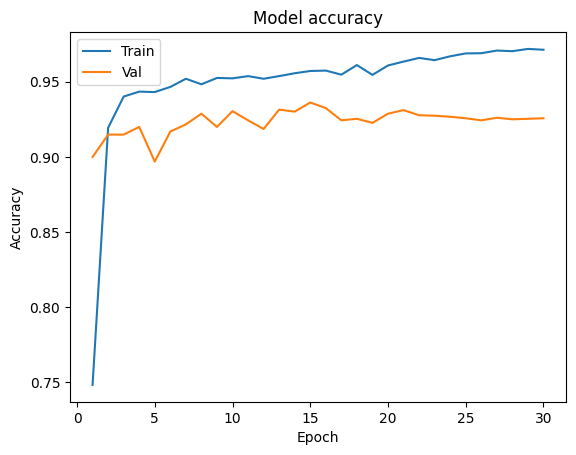

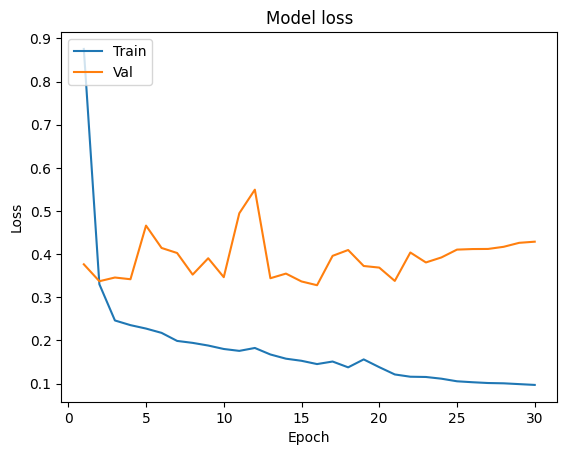

In [303]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, 50)

In [304]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Y_pred = resnet_model.predict(X_val_sc)
y_true_indices = np.argmax(Y_val, axis=1)
y_pred_indices = np.argmax(Y_pred, axis=1)
target_names = list(ACTIVITIES.values())

print("\n--- Classification Report ---")
print(classification_report(y_true_indices, y_pred_indices, target_names=target_names))

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step

--- Classification Report ---
                    precision    recall  f1-score   support

           WALKING       1.00      0.96      0.98       496
  WALKING_UPSTAIRS       0.95      0.99      0.97       471
WALKING_DOWNSTAIRS       0.96      0.96      0.96       420
           SITTING       0.83      0.88      0.85       491
          STANDING       0.89      0.83      0.86       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947

